## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import pickle

## 1. Camera calibration and distorsion correction

In [2]:
def calibrate_camera(nx, ny):
    objp = np.zeros((nx*ny , 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/calibration*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    if len(objpoints) > 0:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape,None,None)
        
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
        
        print('Camera calibrated and calibration saved')
    else:
        ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
        print('Error calibrating')
        
    return ret, mtx, dist, rvecs, tvecs

In [3]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(9,6)

Camera calibrated and calibration saved


In [4]:
img = mpimg.imread('camera_cal/calibration1.jpg')

In [5]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)
print('image undistorted')

image undistorted


Text(0.5, 1.0, 'Undistorted Image')

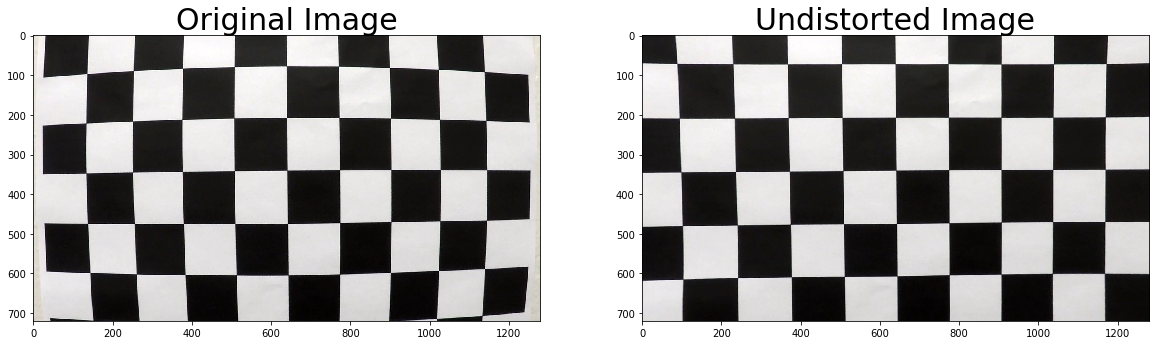

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

This function was created in order to load each image just giving the path and undistorting at the same time.

In [7]:
def load_image(path, display = True):
    image = cv2.imread(path)    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.undistort(image, mtx, dist, None, mtx)
    if display:
        plt.imshow(image)
        plt.title('Image Loaded and undistorted')
    return image

## 3. Color and Gradient

In [8]:
def threshold_combination(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # rgb binary is the same as color binary but and rgb in just white
    rgb_binary = np.zeros(color_binary.shape,dtype = np.int32)
    rgb_binary[:,:,0][color_binary[:,:,1] != 0] = 255
    rgb_binary[:,:,0][color_binary[:,:,2] != 0] = 255
    rgb_binary = np.dstack(( rgb_binary[:,:,0], rgb_binary[:,:,0], rgb_binary[:,:,0]))
    # masked creataed to remove noise inside the two lane lines
    remove_noise_vertices = np.array([[(400, 720), (700, 500),(750, 500), (1050, 720)]])
    cv2.fillPoly(rgb_binary, remove_noise_vertices, (0,0,0))
    
    return color_binary, rgb_binary

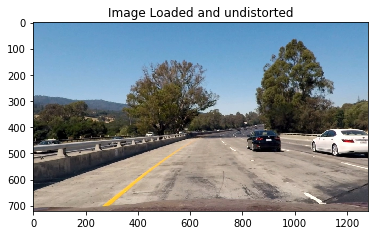

In [9]:
image = load_image('test_images/test1.jpg')

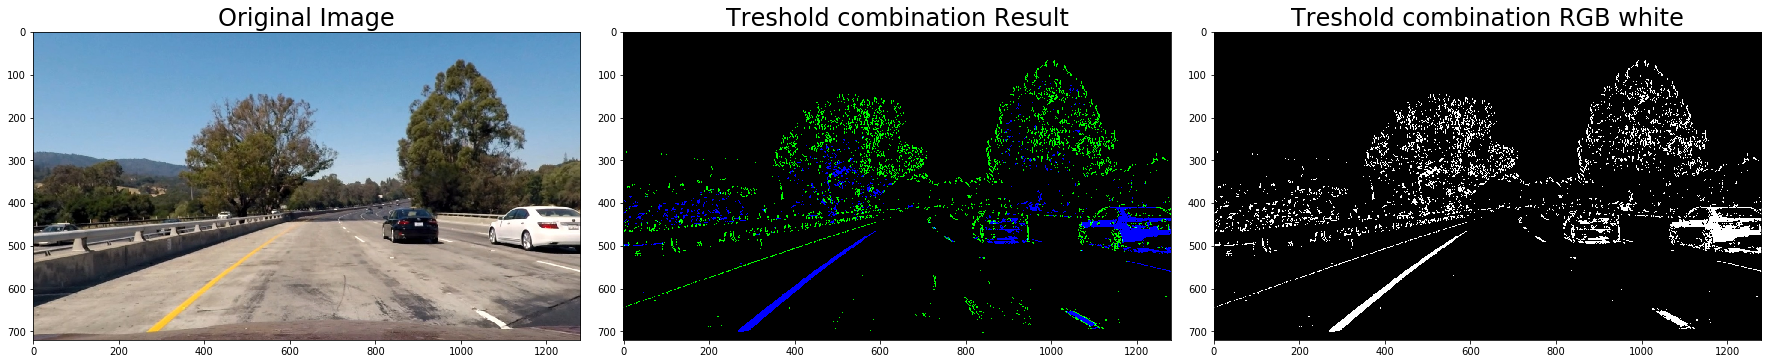

In [10]:
result,rgb_binary = threshold_combination(image,s_thresh= (150, 255), sx_thresh= (30,100))

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(result)
ax2.set_title('Treshold combination Result', fontsize=24)

ax3.imshow(rgb_binary)
ax3.set_title('Treshold combination RGB white', fontsize=24)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The following function was created in order to take a look at if the thersholds are showing clearly the lane lines

In [11]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

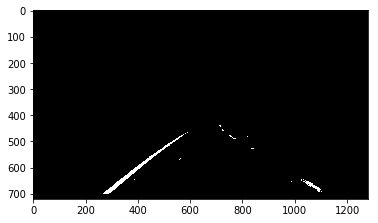

In [12]:
vertices = np.array([[(150, 720), (590, 450), (735, 420), (1150, 720)]])
image_region_interest = region_of_interest(rgb_binary, vertices)
plt.imshow(image_region_interest)

In [13]:
def threshold_and_region(image,s_thresh= (150, 255), sx_thresh= (30,100), get_region = True):
    thresholds_combined, rgb_binary = threshold_combination(image,s_thresh, sx_thresh)
    if get_region:
        vertices = np.array([[(150, 720), (590, 450), (735, 420), (1150, 720)]])
        image_region_interest = region_of_interest(rgb_binary, vertices)
        return image_region_interest
    return rgb_binary

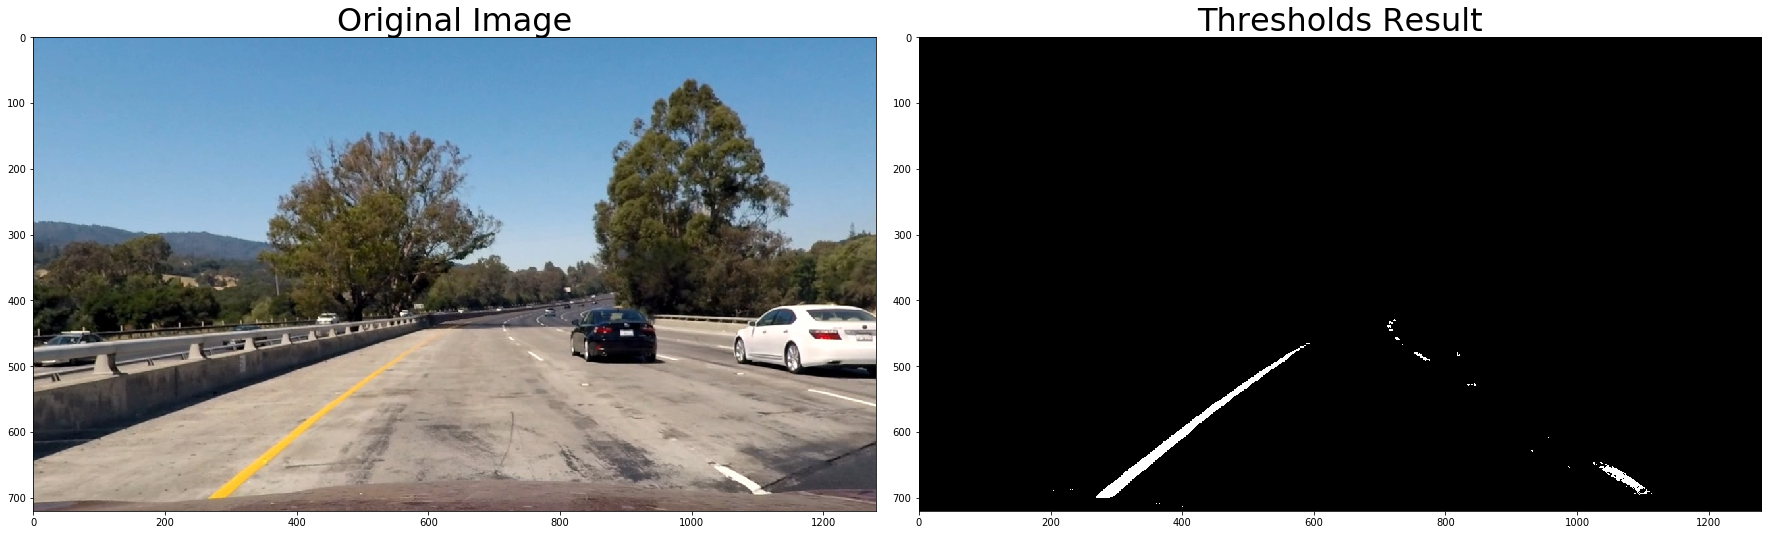

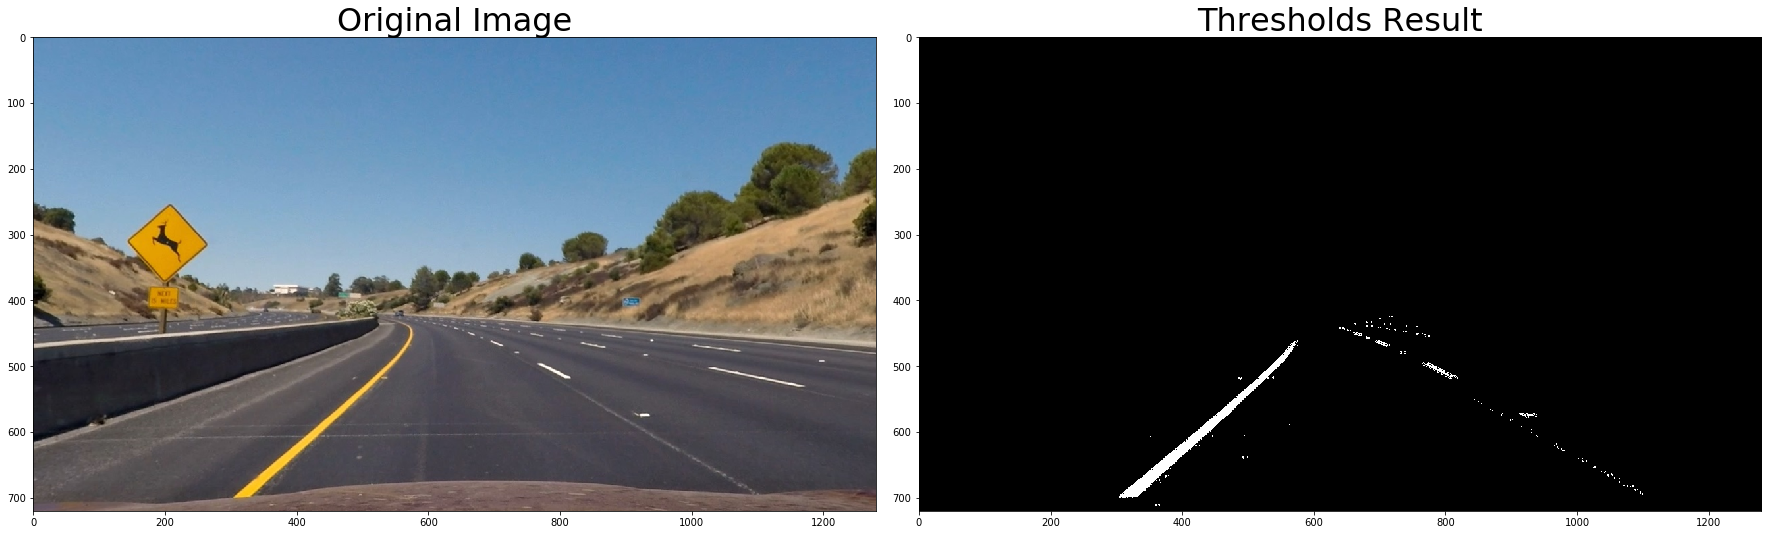

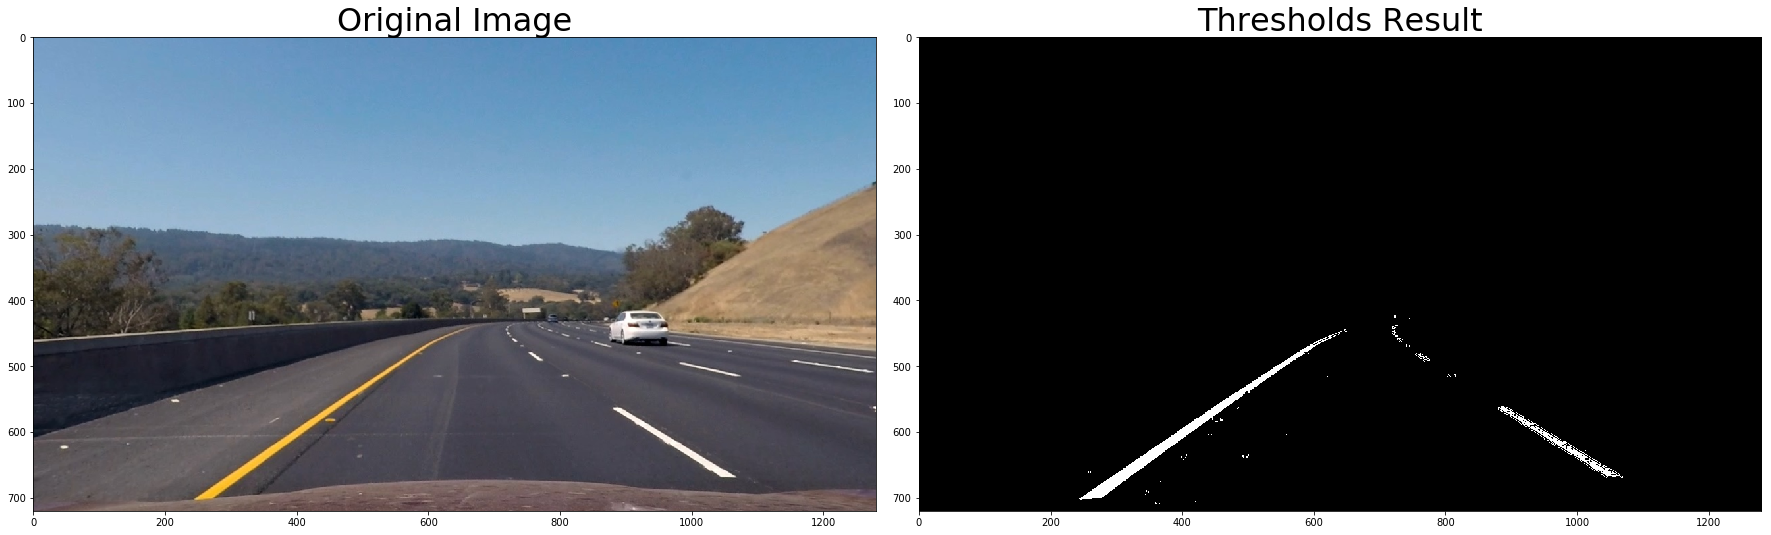

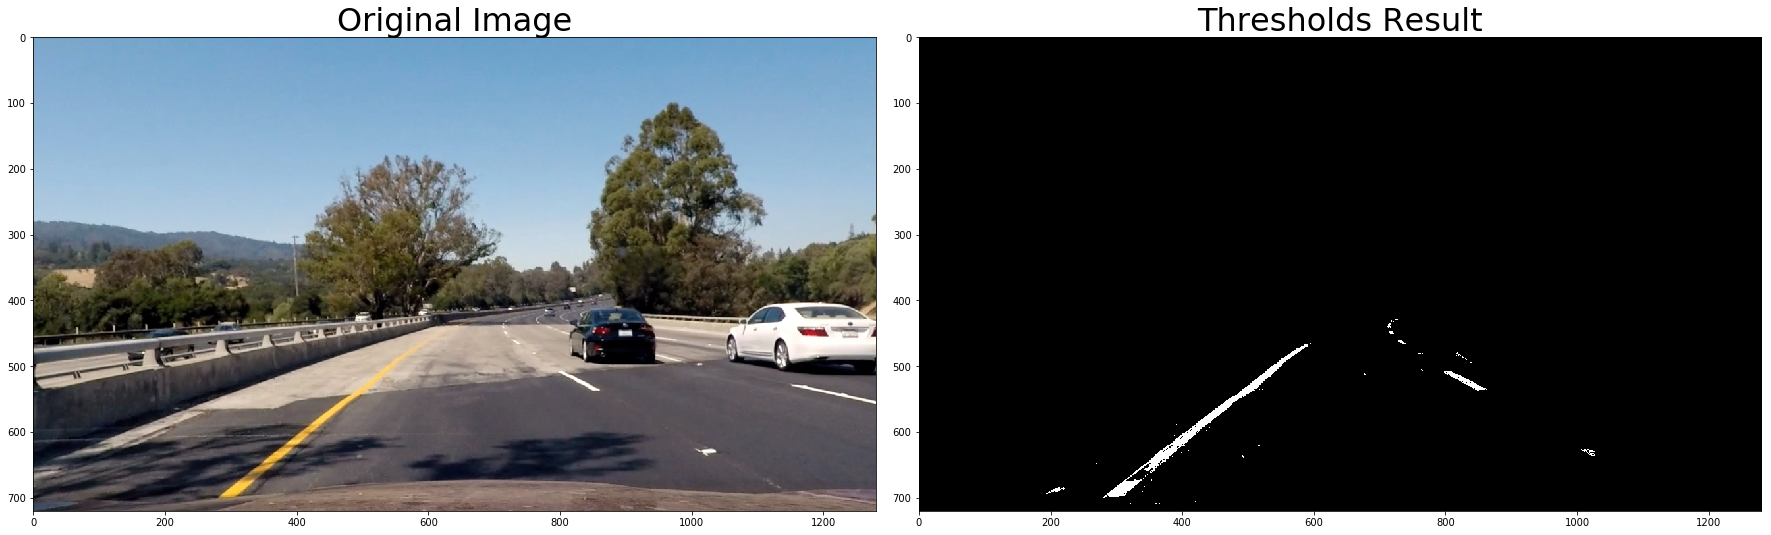

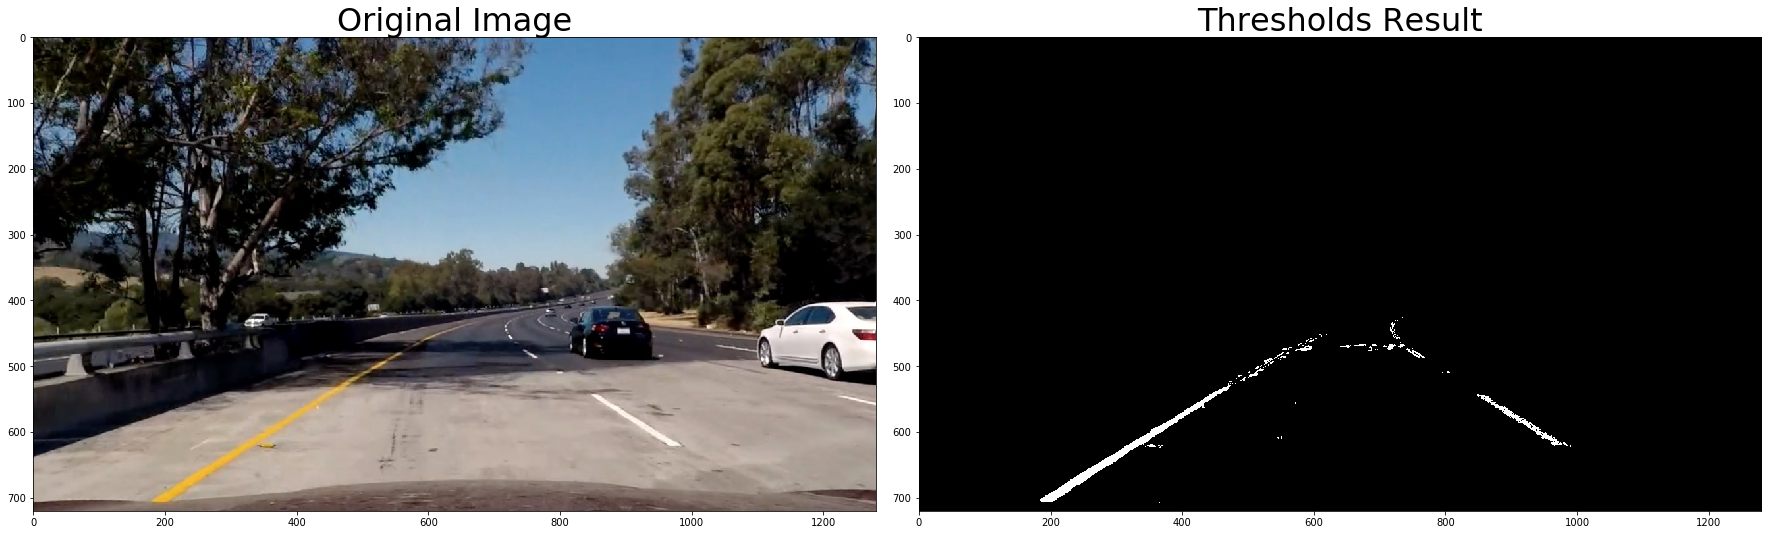

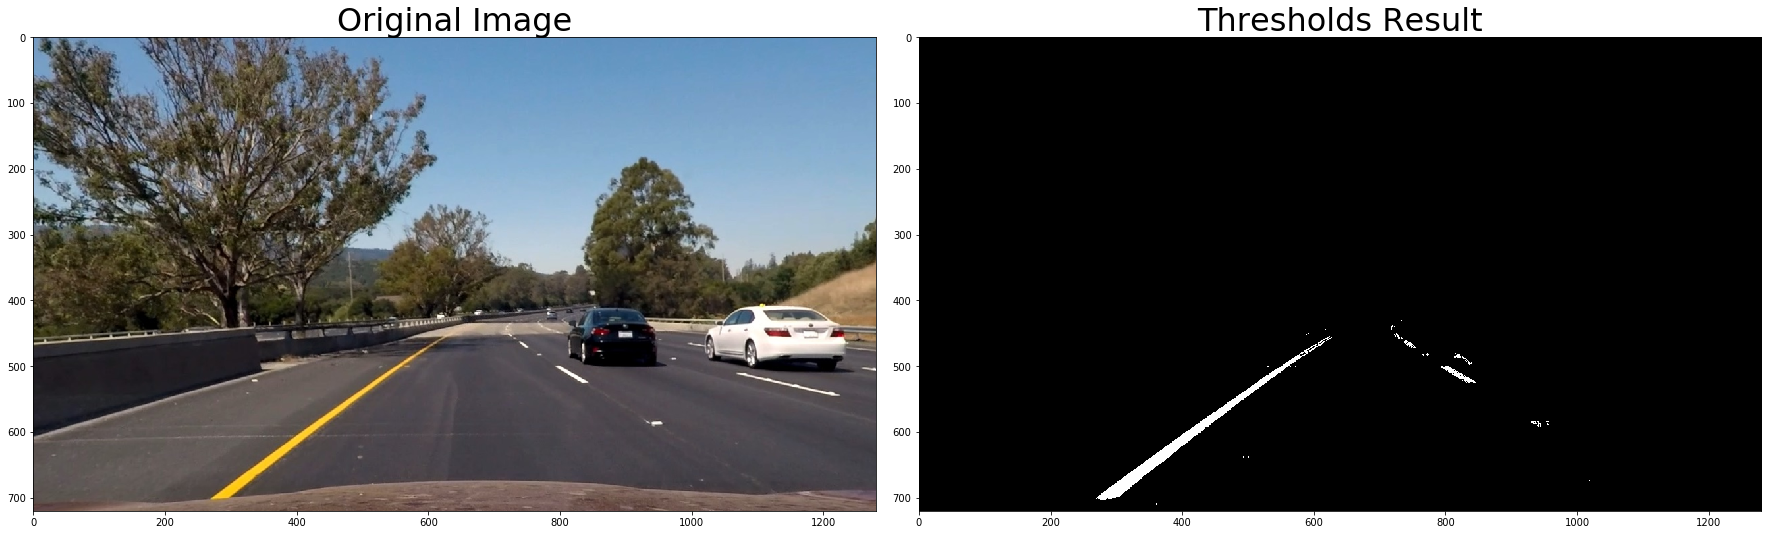

In [14]:
for i in range(1, 7):
    fname = 'test_images/test{}.jpg'.format(i)
    image = load_image(fname,display= False)
    result = threshold_and_region(image, s_thresh = (150,255) ,sx_thresh=(30,100))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=32)

    ax2.imshow(result)
    ax2.set_title('Thresholds Result', fontsize=32)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Perspective transform

The function perspective_transform receives an image and returns the same image but in bird's eye view

In [15]:
def perspective_transform(image, src = None, dst = None, inverse = False):
    
    img_size = (image.shape[1], image.shape[0])
    
    if src == None:
        src = np.float32([[270, 700], [600,460], [728,460], [1080, 700]])
    if dst == None:    
        dst = np.float32([[250, 720 ], [290, 0], [1060, 0], [1100, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    if inverse:
        M = cv2.getPerspectiveTransform(dst, src) 
        
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, warped

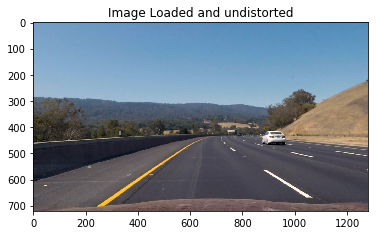

In [16]:
%matplotlib inline
image = load_image('test_images/test3.jpg')

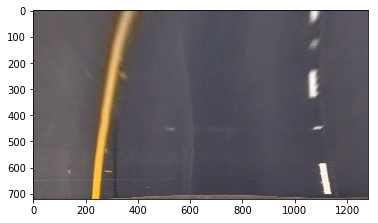

In [17]:
src_coordinates = np.float32([[270, 700], [600,460], [728,460], [1080, 700]])
dst_coordinates = np.float32([[250, 720, ], [290, 0], [1060, 0], [1100, 720]])

matrix_transformation, warped_image = perspective_transform(image)
plt.imshow(warped_image)

## 5. Lines

In the following cell some lines among the points given before

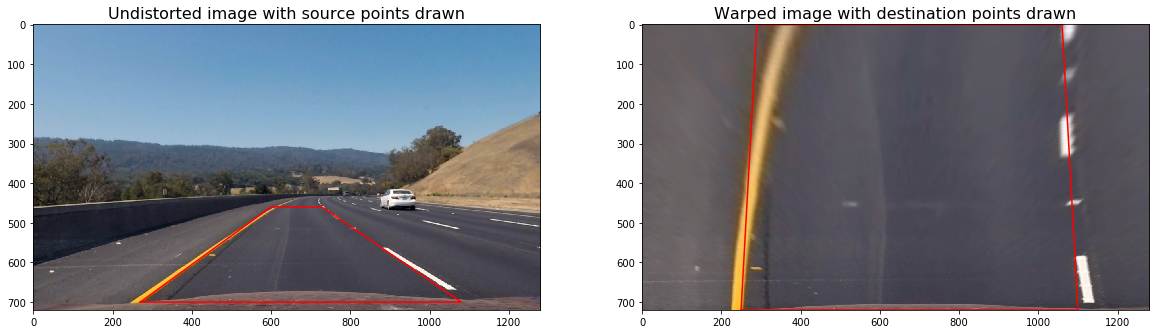

In [18]:
from matplotlib.patches import Polygon

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(image)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_image)

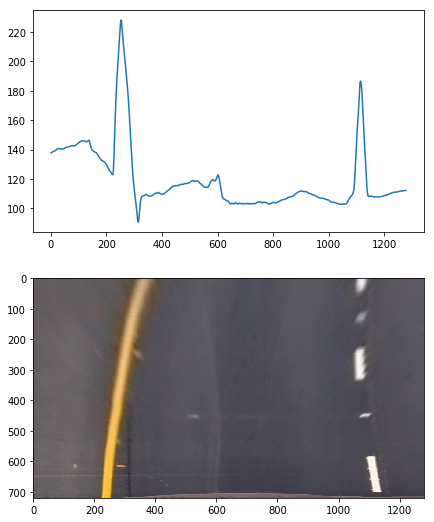

In [19]:
def get_histogram(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img/255
    return np.sum(img[img.shape[0]//2:,:], axis=0)

histogram = get_histogram(warped_image)

f, (ax1, ax2) = plt.subplots(2,1,figsize=(7,9))
ax1.plot(histogram)
ax2.imshow(warped_image)

In the following cell we take the image in bird's eye view and then we pass it inside the threshold_combination function

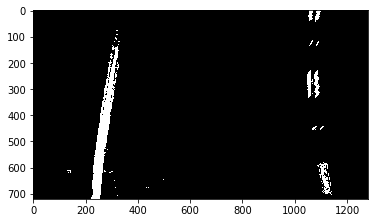

In [20]:
_,binary_warped = threshold_combination(warped_image,s_thresh=(150,255), sx_thresh=(30,100))
plt.imshow(binary_warped)

In [21]:
def find_lane_pixels(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    histogram = get_histogram(out_img)    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [22]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

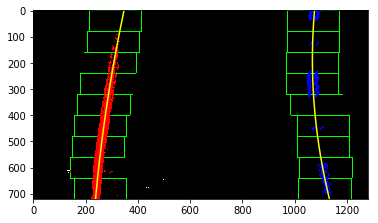

In [23]:
np.clip(binary_warped, 0, 255, out=binary_warped)
binary_warped = binary_warped.astype('uint8')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
lines_fit, left_points, right_points, out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

In [24]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [25]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

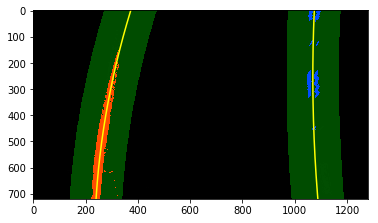

In [26]:
# Run image through the pipeline
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [27]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [28]:
_,result_inv = perspective_transform(result, inverse=True)

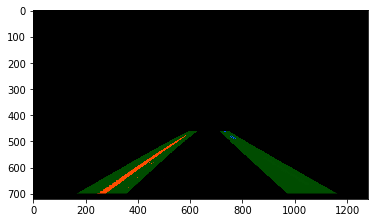

In [29]:
plt.imshow(result_inv)

In [30]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    # print(img.shape)
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # print(pts.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    plt.imshow(warp_zero)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    _,newwarp = perspective_transform(warp_zero, inverse=True) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [31]:
_, Minv = perspective_transform(warped_image, inverse=True)

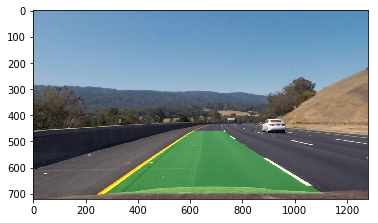

In [32]:
# Run the function
img_lane = draw_lane(image, warped_image, left_points, right_points, Minv)

# Plot the results
plt.imshow(img_lane)

In [33]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [34]:
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.20953674863980115 m.


In [35]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

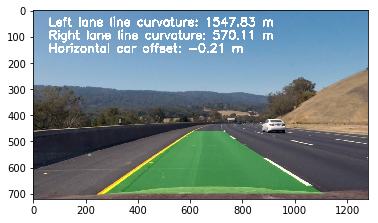

In [36]:
# Run the function
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the results
plt.imshow(out_img)

In [37]:
def final_pipeline(image):
    # undistort image
    image = cv2.undistort(image, mtx, dist, None, mtx)
    # get the image in bird's eye view
    matrix_transformation, warped_image = perspective_transform(image)
    # apply thresholds combination to the image
    _,binary_warped = threshold_combination(warped_image,s_thresh=(150,255), sx_thresh=(30,100))
    
    np.clip(binary_warped, 0, 255, out=binary_warped)
    binary_warped = binary_warped.astype('uint8')
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    # get points to fit green rectangle
    lines_fit, left_points, right_points, out_img = fit_polynomial(binary_warped)
    # get lane lines from bird's eye view to normal
    _, Minv = perspective_transform(warped_image, inverse=True)
    # draw green rectangle in image
    img_lane = draw_lane(image, warped_image, left_points, right_points, Minv) 
    # get car distance from the center
    offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
    # get image with metrics in the top 
    out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
    
    return out_img

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def process_image(image):
    result = final_pipeline(image)
    return result

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/project_video_result.mp4.
Moviepy - Writing video videos/project_video_result.mp4



Moviepy - Done !
Moviepy - video ready videos/project_video_result.mp4
CPU times: user 5min 12s, sys: 17.6 s, total: 5min 30s
Wall time: 3min 56s


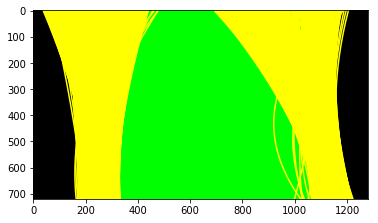

In [40]:
white_output = 'videos/project_video_result.mp4'

clip1 = VideoFileClip("videos/project_video.mp4")

white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [45]:
# white_output = 'videos/challenge_video_result.mp4'

# clip1 = VideoFileClip("videos/challenge_video.mp4")

# white_clip = clip1.fl_image(process_image) 
# %time white_clip.write_videofile(white_output, audio=False)

In [43]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))

In [44]:
# white_output = 'videos/harder_challenge_video_result.mp4'

# clip1 = VideoFileClip("videos/harder_challenge_video.mp4")

# white_clip = clip1.fl_image(process_image) 
# %time white_clip.write_videofile(white_output, audio=False)